# Trees classification using CNN and transfer learning
The goal of the project is to classify if given tree is a pine or an oak, by using a photo of its bark. 

Classifier is based on existing convolutional neural network from keras library: *MobileNet*. This model is trained on large dataset which contains 1000 classes, but by using transfer learning it will be adapted to trees case.

## Install dependencies
Packages used in project:
- numpy
- keras
- scikit-learn
- IPython
- PIL

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import accuracy
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load data
Used data contains 199 photos of trees:
- 89 of oak
- 110 of pine

First we'd like to import images into list.

Working with 89 oak and 110 pine images
5 random oak image examples: 


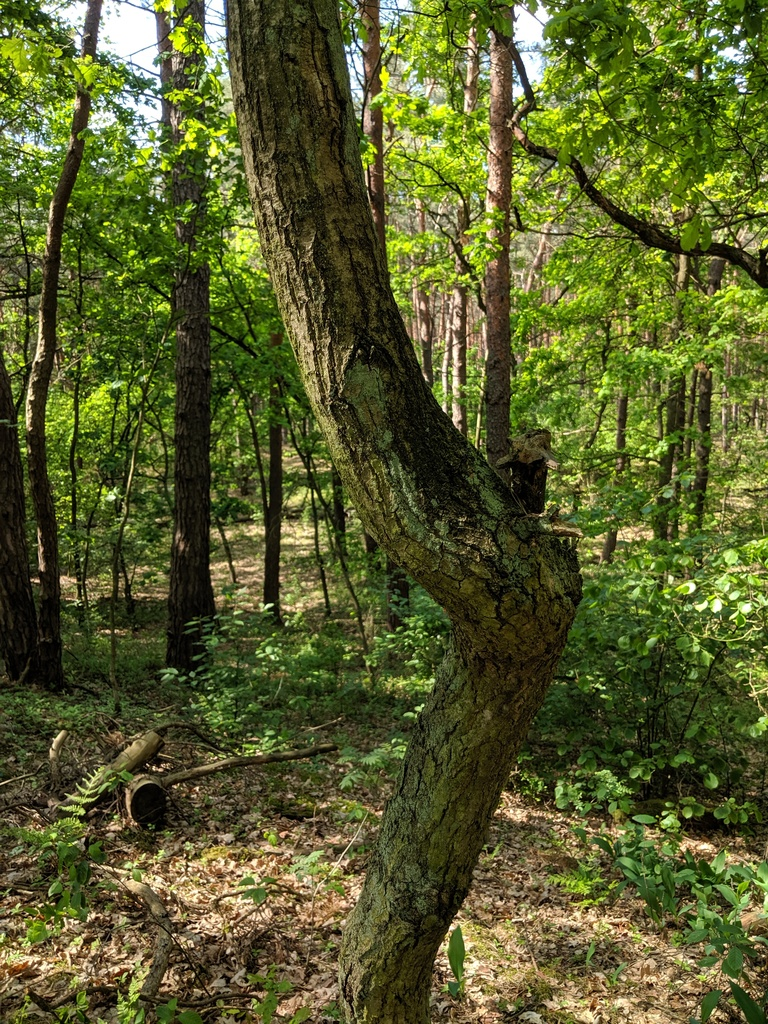

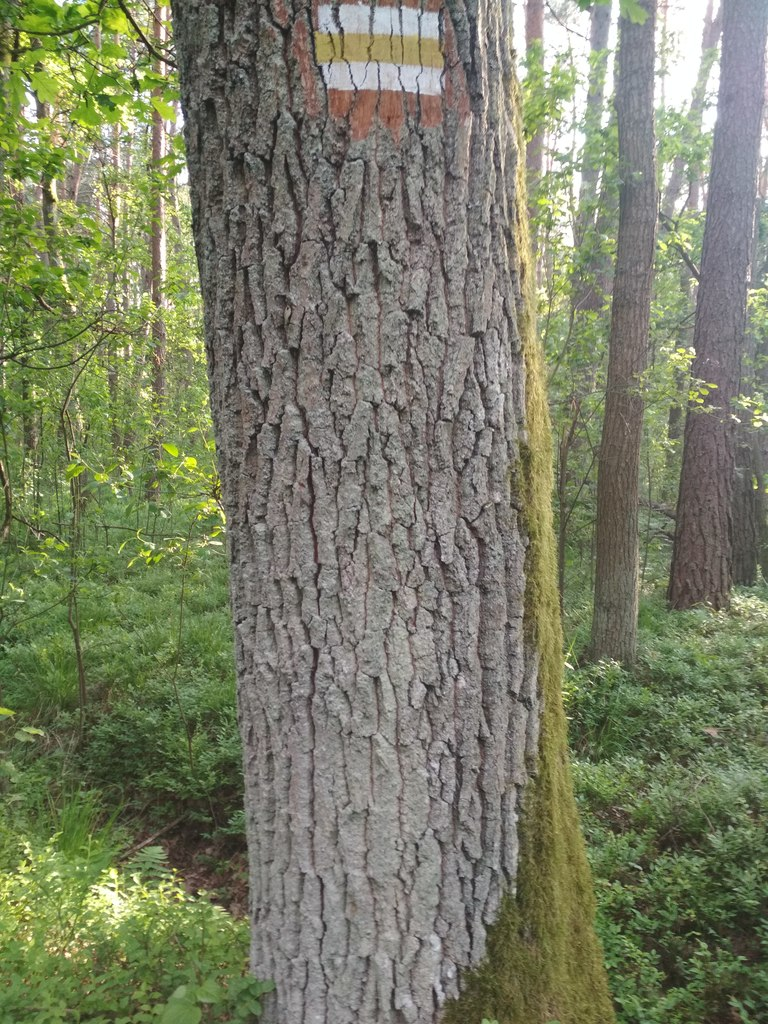

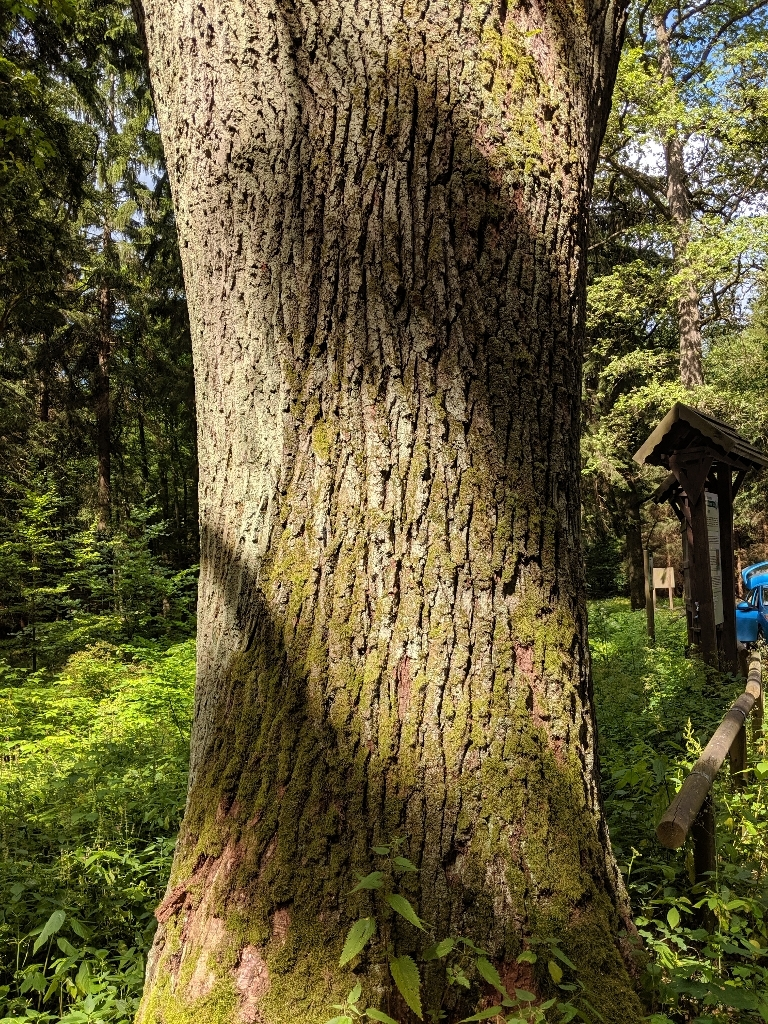

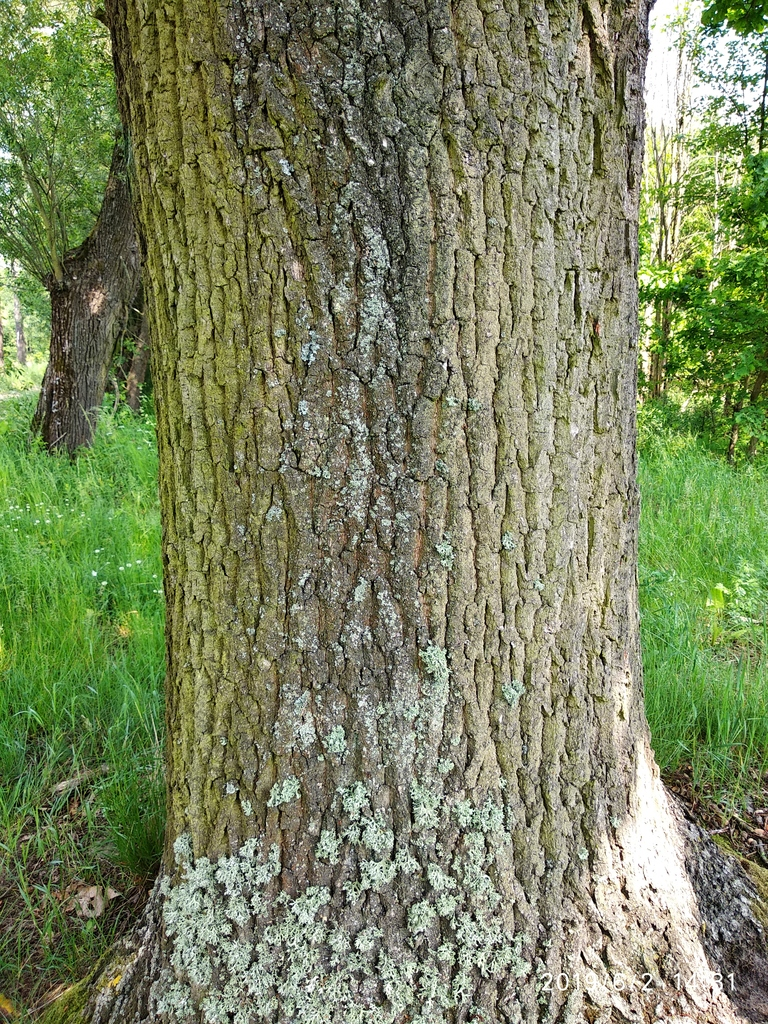

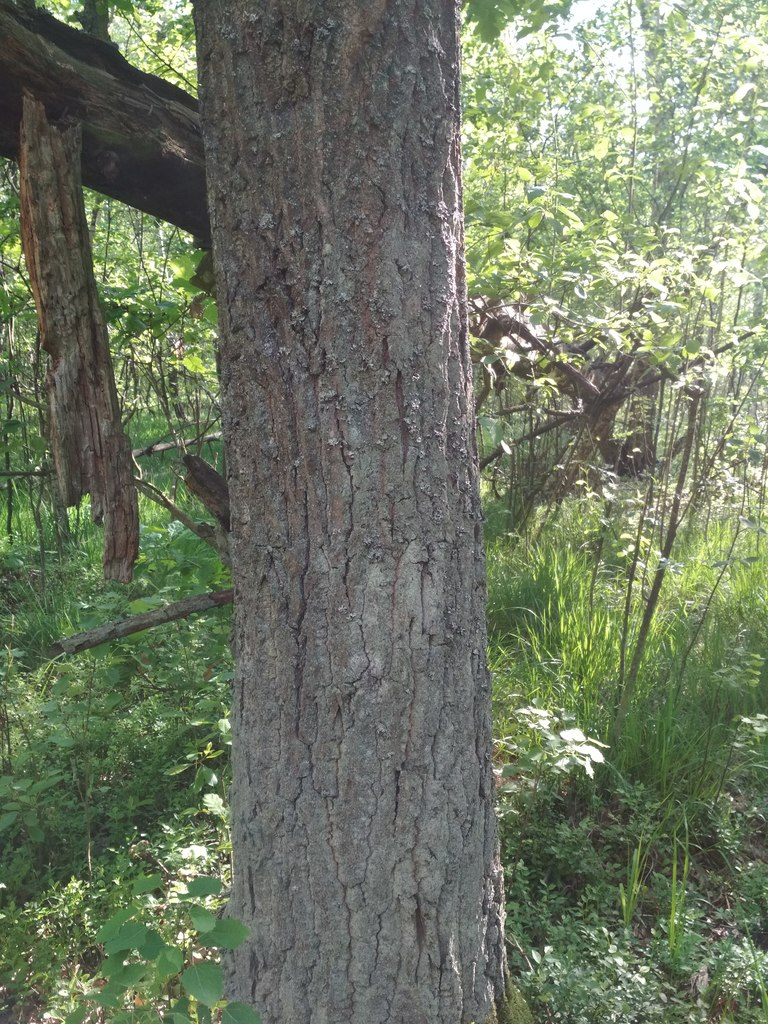

and 5 random pine image examples: 


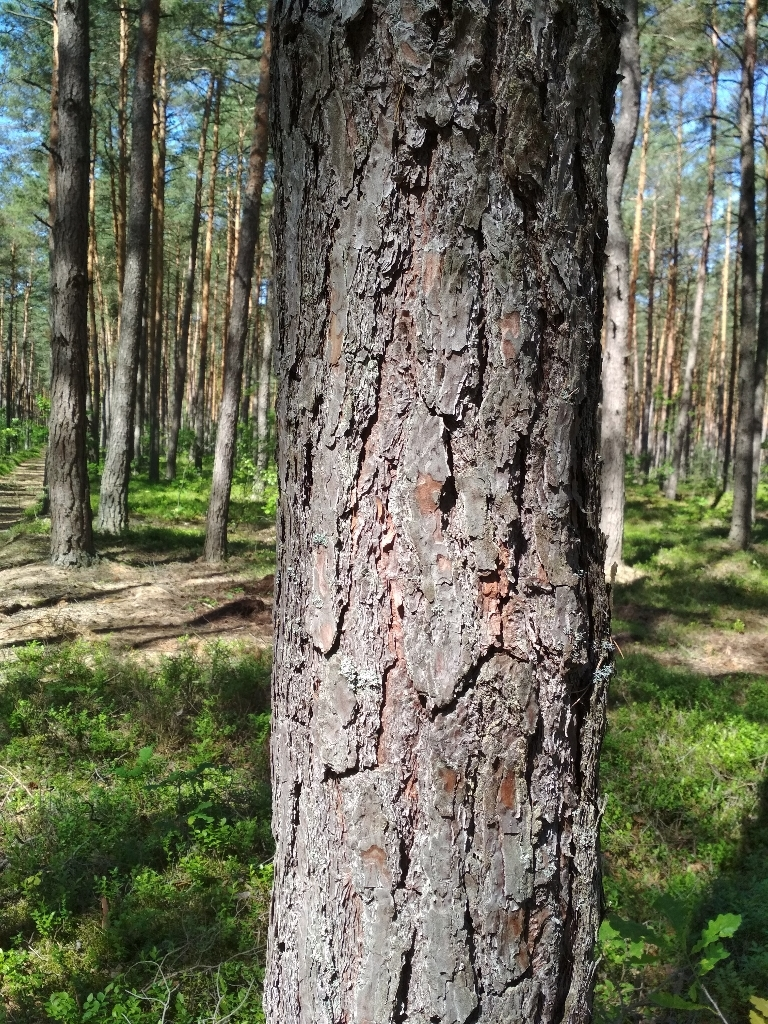

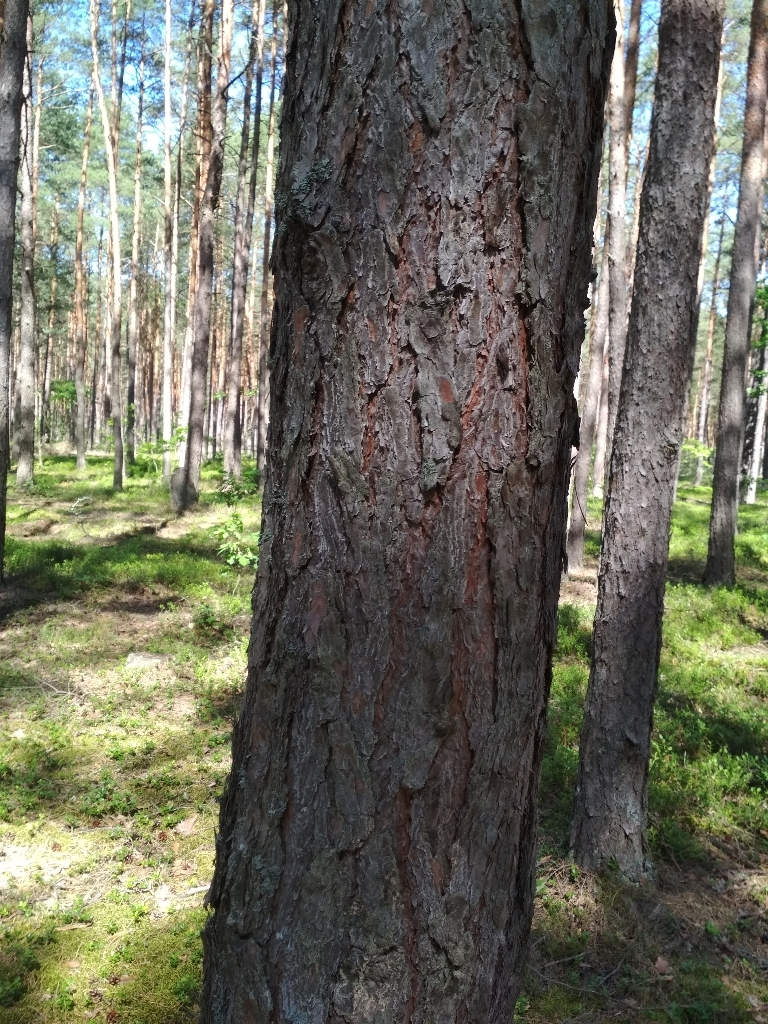

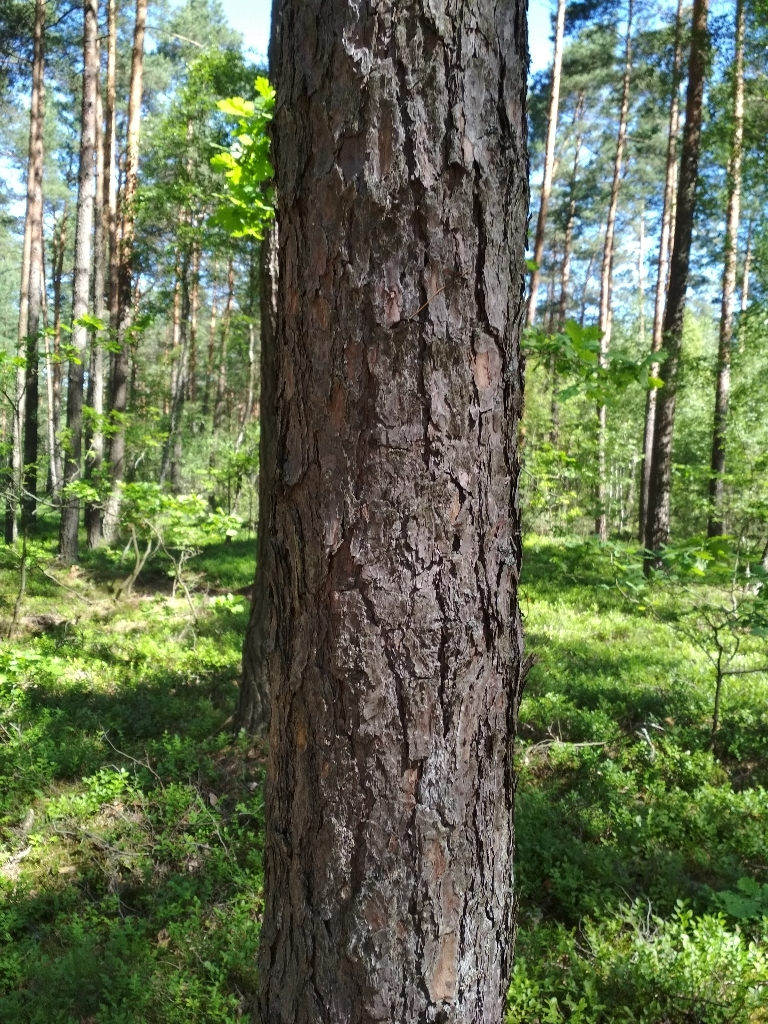

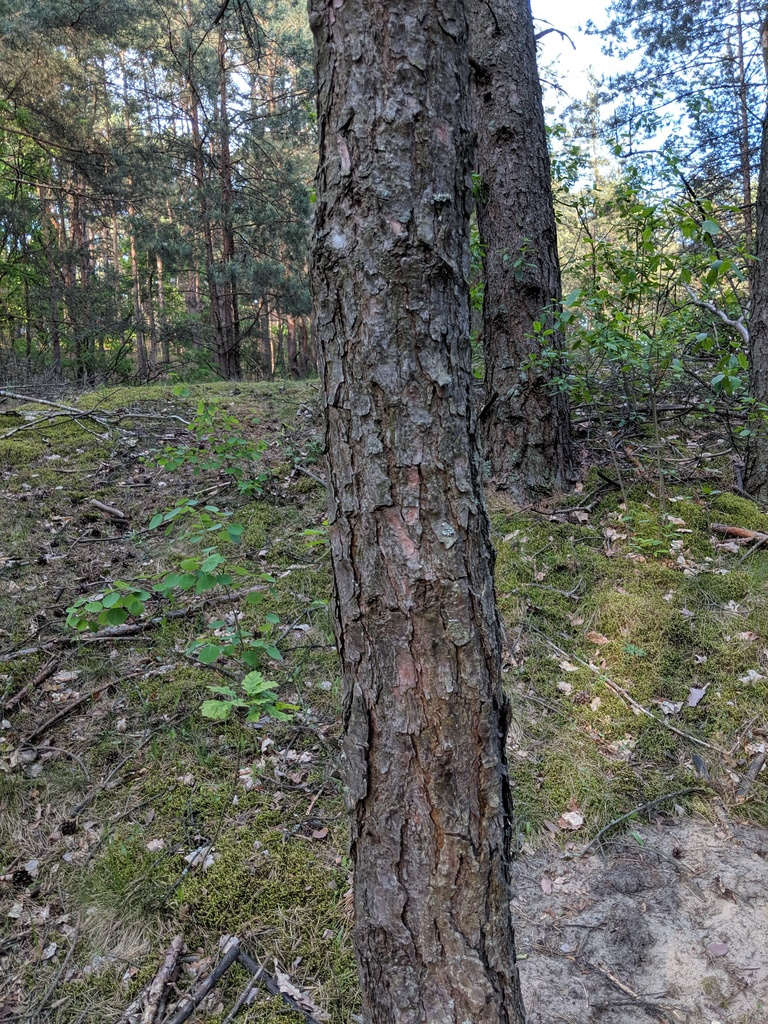

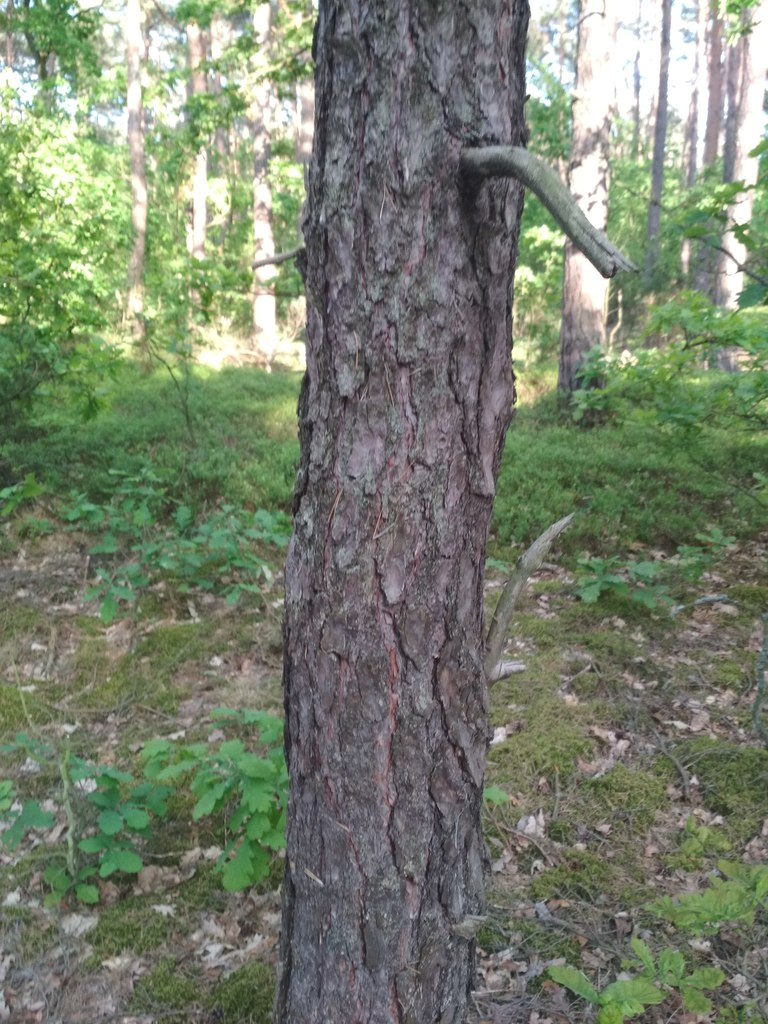

In [2]:
folder_oak = "./data/oak"
imgs_oak = [f for f in os.listdir(folder_oak) if (os.path.isfile(os.path.join(folder_oak, f)) and os.path.splitext(f)[1]=='.jpg')]
folder_pine = "./data/pine"
imgs_pine = [f for f in os.listdir(folder_pine) if (os.path.isfile(os.path.join(folder_pine, f))and os.path.splitext(f)[1]=='.jpg')]
print("Working with {0} oak and {1} pine images".format(len(imgs_oak),len(imgs_pine)))

from random import choice

print("5 random oak image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_oak + "/" + imgs_oak[choice(range(len(imgs_oak)))], width=240, height=320))
print("and 5 random pine image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_pine + "/" + imgs_pine[choice(range(len(imgs_pine)))], width=240, height=320))

## Prepare data
We have two lists with filenames of oak and pine images. To input them into model, we have to convert them to numerical array. Pictures are in 768 x 1024 resolution. As it would be too much amount of data, images are thumbnailed 4 times.

In [3]:
labels = len(imgs_oak)*['oak'] + len(imgs_pine)*['pine']

In [4]:
def load_photos(imgs, treename, IMG_WIDTH = 768, IMG_HEIGHT = 1024):     
    channels = 3
    dataset = np.ndarray(shape=(len(imgs), channels, IMG_HEIGHT, IMG_WIDTH),
                         dtype=np.float32)

    for i, f in enumerate(imgs):
        img = load_img('./data/' + treename + '/' + f)
        img.thumbnail((IMG_WIDTH, IMG_HEIGHT))
        x = img_to_array(img)
        x = x.reshape((3, IMG_HEIGHT, IMG_WIDTH))
        dataset[i] = x
    return dataset

In [5]:
img_width = 768//3
img_height = 1024//3

In [6]:
ds_oak = load_photos(imgs_oak, 'oak', IMG_WIDTH = img_width, IMG_HEIGHT = img_height)
ds_pine = load_photos(imgs_pine, 'pine', IMG_WIDTH = img_width, IMG_HEIGHT = img_height)
dataset_non_norm = np.concatenate([ds_oak, ds_pine], axis=0)

The numpy array includes info about every pixel in images. The values are in 0 to 255 range. To put data into model, it's necessary to format it to <0;1> range. Let's do *min-max normalization*: 

In [7]:
dataset = (dataset_non_norm - dataset_non_norm.min())/(dataset_non_norm.max() - dataset_non_norm.min())
dataset

array([[[[0.14901961, 0.1882353 , 0.16470589, ..., 0.09803922,
          0.09411765, 0.07058824],
         [0.07450981, 0.07450981, 0.1254902 , ..., 0.2       ,
          0.21568628, 0.21568628],
         [0.2       , 0.24313726, 0.2509804 , ..., 0.5803922 ,
          0.6862745 , 0.6431373 ],
         ...,
         [0.36078432, 0.3019608 , 0.30980393, ..., 0.24313726,
          0.26666668, 0.28235295],
         [0.32941177, 0.35686275, 0.38039216, ..., 0.35686275,
          0.3372549 , 0.46666667],
         [0.4862745 , 0.47058824, 0.32941177, ..., 0.30980393,
          0.4       , 0.4       ]],

        [[0.3647059 , 0.2627451 , 0.26666668, ..., 0.28235295,
          0.30588236, 0.3254902 ],
         [0.22745098, 0.25490198, 0.2784314 , ..., 0.26666668,
          0.24705882, 0.44705883],
         [0.4627451 , 0.44705883, 0.42352942, ..., 0.28627452,
          0.2784314 , 0.2784314 ],
         ...,
         [0.30588236, 0.3019608 , 0.2509804 , ..., 0.34901962,
          0.31764707, 0.3

## First model
As we have prepared dataset with labels, we can try to do first model. There's no a lot of photos, so accurracy of model may be really poor, and it would be necessary to do some data augmentation. But for the first we are going to work on starting dataset and do only simple split, without cross validation.
### Split data
We do simple split on dataset - for train, validation and test sets.

In [14]:
X_tr, X_test, y_tr, y_test = train_test_split(dataset, labels,
                                                    test_size=0.1, random_state=33)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=1)
print("Train set size: {0}, Validation set size: {1}, Test set size: {2}"
        .format(len(y_tr), len(y_val), len(y_test)))

Train set size: 143, Validation set size: 36, Test set size: 20


Data have to be preprocessed before passing it to the model. We will use *Image Data Generator* for this purpose. 

We have to remember, that our training output data is provided by the list:

In [15]:
y_tr

['pine',
 'oak',
 'oak',
 'pine',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'oak',
 'pine',
 'pine',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'oak',
 'pine',
 'oak',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'pine',
 'pine',
 'pine',
 'oak',
 'oak',
 'oak',
 'oak',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'oak',
 'oak',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'oak',
 'oak',
 'oak',
 'pine',
 'pine',
 'pine',
 'pine',
 'oak',
 'pine',
 'oak',
 'oak',
 'pine',
 'oak',
 'pine',
 'oak',
 'oak',
 'oak',
 'oak',
 'oak',
 'oak',
 'pine',
 'oak',
 'pine',
 'pine',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'oak',
 'oak',
 'oak',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'oak',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'pine',
 'oak',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'pine',
 'oak',
 'oak',
 'pine',
 'pine',
 'pine',
 'pine',
 'pine',
 'oak',
 'pine',
 'pine',
 'p

To correct that fact, we have to change list of labels to categorical matrix. We have to first correct list of labels into integers before use *to_categorical* from keras.

In [16]:
y_tr = [0 if label=='oak' else 1 for label in y_tr]
y_tr = to_categorical(y_tr)
y_val = [0 if label=='oak' else 1 for label in y_val]
y_val = to_categorical(y_val)
y_test = [0 if label=='oak' else 1 for label in y_test]
y_test = to_categorical(y_test)
y_tr

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

### Import pre-trained model
We will use *MobileNet* model from keras library. This model is trained on large dataset with 1000 neurons in last layer, for each class in dataset. Due the fact that we have only 2 classes in our dataset, we will discard this layer by setting property *include_top=False*.

In [17]:
mob_net = MobileNet(weights='imagenet', include_top=False)

c:\users\errry\pycharmprojects\treeclassification\venv\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


We can add last layer with 2 neurons and softmax function.

In [18]:
x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outs = Dense(2, activation='softmax')(x)

Now we merge this layer with *MobileNet* model.

In [19]:
model = Model(inputs=mob_net.input, outputs=outs)

for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

The model has 89 layers:
- 1 input
- 86 convolutional internal layers
- 1 global average pooling layer to connect network with our final layer
- 1 dense layer that we will train
- 1 output layer

Because we use transfer learning, we don't need to train layers from imported model. We will train only layer which we added:

In [20]:
for layer in model.layers[:87]:
    layer.trainable=False
for layer in model.layers[87:]:
    layer.trainable=True

### Compile and fit model
We can compile model with *Adam* optimizer and use categorical cross entropy as loss function. After that we fit it to our training dataset.

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
X_tr = X_tr.reshape((X_tr.shape[0], img_width, img_height, 3))
X_val = X_val.reshape((X_val.shape[0], img_width, img_height, 3))

model.fit(X_tr, y_tr, batch_size=4, epochs=5, validation_data=(X_val, y_val))

Train on 143 samples, validate on 36 samples
Epoch 1/5
143/143 [==============================] - 20s 141ms/step - loss: 1.9686 - accuracy: 0.5315 - val_loss: 0.6300 - val_accuracy: 0.6667
Epoch 2/5
143/143 [==============================] - 22s 157ms/step - loss: 0.7509 - accuracy: 0.5664 - val_loss: 0.6477 - val_accuracy: 0.6667
Epoch 3/5
143/143 [==============================] - 23s 160ms/step - loss: 0.5865 - accuracy: 0.6713 - val_loss: 0.6977 - val_accuracy: 0.6944
Epoch 4/5
143/143 [==============================] - 26s 184ms/step - loss: 0.7975 - accuracy: 0.5245 - val_loss: 0.6603 - val_accuracy: 0.6389
Epoch 5/5
143/143 [==============================] - 26s 183ms/step - loss: 0.6061 - accuracy: 0.6713 - val_loss: 0.5903 - val_accuracy: 0.5833


Finally, we have fited our first model. It was fited only with 1 *epoch*, with *batch_size*, and on data splited into one training set of 169 photos from 199.

Accuracy of this model is 0.5385, and loss is 1.8514. We can save weights of the model:

In [22]:
model.save_weights('./model_weights/mod_1.h5')

### Predictions of first model
Let's use model to predict classes of test set.

In [23]:
X_test = X_test.reshape((X_test.shape[0],img_width,img_height,3))
preds = model.predict(X_test, batch_size=4)

In [24]:
preds = np.round(preds, decimals=0)
preds

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [25]:
y_test == preds

array([[False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [26]:
np.mean(y_test == preds)

0.65

As we can see, predictions are really poor: model classify almost every image to first class, 'oak', and only 3 examples are classified to 'pine'. Accuracy on test set is only 37%.

Now we have a good point of reference, to do next, better model.
## Evaluation of the first model
For the first we will add layers into model

In [27]:
x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
outs2 = Dense(2,activation='softmax')(x) 

model2 = Model(inputs=mob_net.input, outputs=outs2)

for i, layer in enumerate(model2.layers):
    print(i, layer.name)
    
for layer in model2.layers[:87]:
    layer.trainable=False
for layer in model2.layers[87:]:
    layer.trainable=True

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

Now model is constructed with 2 dense layers with relu activation function. As in the previous model, only new layers will be trained. To improve process of training, number epochs will be increased to 8, and size of batch will be divided by 2.

In [28]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_tr, y_tr, batch_size=4, epochs=5, validation_data=(X_val, y_val))

Train on 143 samples, validate on 36 samples
Epoch 1/5
143/143 [==============================] - 23s 164ms/step - loss: 1.0340 - accuracy: 0.5385 - val_loss: 0.6798 - val_accuracy: 0.6667
Epoch 2/5
143/143 [==============================] - 26s 179ms/step - loss: 0.7507 - accuracy: 0.4545 - val_loss: 0.6734 - val_accuracy: 0.6667
Epoch 3/5
143/143 [==============================] - 25s 173ms/step - loss: 0.6973 - accuracy: 0.5874 - val_loss: 0.6565 - val_accuracy: 0.6389
Epoch 4/5
143/143 [==============================] - 24s 170ms/step - loss: 0.6907 - accuracy: 0.4965 - val_loss: 0.6398 - val_accuracy: 0.6389
Epoch 5/5
143/143 [==============================] - 24s 167ms/step - loss: 0.6557 - accuracy: 0.6224 - val_loss: 0.6315 - val_accuracy: 0.6389


Accuracy on train dataset is 0.5503 and loss 2.2386.

In [29]:
model2.save_weights('./model_weights/mod_2.h5')

In [32]:
preds2 = model2.predict(X_test,batch_size=4)
preds2 = np.round(preds2, decimals=0)
preds2

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
np.mean(y_test == preds2)

0.55

Accuracy of predictions on test set increased from 37% to 47%. That is quite good improvement. Changes that we have made:
- 1 new layers added to model
- increased number of epochs from 1 to 8
- smaller size of batch of data: from 32 to 16

Let's head to next improvement: data augmentation to increase training dataset.

## Second try: Data Augmentation
Our dataset is rather small, it contains only two hundreds of pictures. As we saw some examples at the begin of the notebook, the pictures are quite similar - each of them is taken vertically and from similar distance.

As the pictures are taken vertically, the chosen augmentation operations are:
- random horizontal shift (50 pixels to right or left)
- random rotation (in range of 90 degrees)
- random horizontal flip
- random zoom (between 0.5 and 1.0) 


In [34]:
def generate_aug_photos(samples, treename, imgs_count, aug_index):
    samples = samples.reshape((samples.shape[0], samples.shape[2], samples.shape[3], 3))
    ds = np.ndarray(shape=(imgs_count, samples.shape[1], samples.shape[2], 3),
                         dtype=np.float32)
    datagen2 = ImageDataGenerator(width_shift_range=[-50,50], rotation_range=90, horizontal_flip=True,
                                  zoom_range=[0.5,1.0], rescale=1.0/255.0)
    datagen2.fit(samples)
    for batch in datagen2.flow(samples, batch_size=imgs_count):
        for i in range(imgs_count):
            ds[i] = batch[i]
            str_file = 'data/aug/'+ treename + '/aug_' +str(aug_index)+'_'  + str(i)+'.jpg'
            if os.path.isfile(str_file):
                os.remove(str_file) 
            plt.imsave(str_file, batch[i])
        break
    return ds

After creating function to generate augmented photos, we will call it 3 times for each class to generate 3 times more pictures for every class.

In [35]:
ds_oak2 = load_photos(imgs_oak, 'oak', IMG_WIDTH=768//3, IMG_HEIGHT=1024//3)
ds_pine2 = load_photos(imgs_pine, 'pine', IMG_WIDTH=768//3, IMG_HEIGHT=1024//3)
  
tmp1 = generate_aug_photos(ds_oak2, 'oak', 89, 1)
tmp2 = generate_aug_photos(ds_oak2, 'oak', 89, 2)
tmp3 = generate_aug_photos(ds_oak2, 'oak', 89, 3)
ds_oak2_aug = np.concatenate([tmp1,tmp2,tmp3], axis=0)
tmp1 = generate_aug_photos(ds_pine2, 'pine', 110, 1)
tmp2 = generate_aug_photos(ds_pine2, 'pine', 110, 2)
tmp3 = generate_aug_photos(ds_pine2, 'pine', 110, 3)
ds_pine2_aug = np.concatenate([tmp1,tmp2,tmp3], axis=0)

In [36]:
del tmp1, tmp2, tmp3

Let's look at 5 random augmented images from each class.

Working with 356 oak and 440 pine augmented images
5 random oak augmented image examples: 


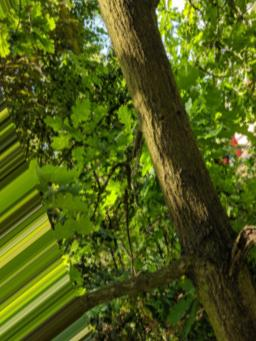

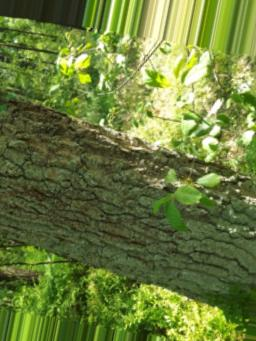

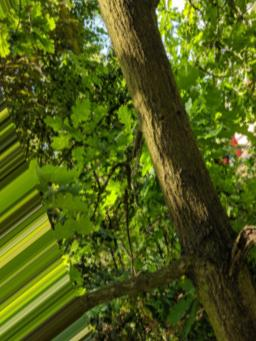

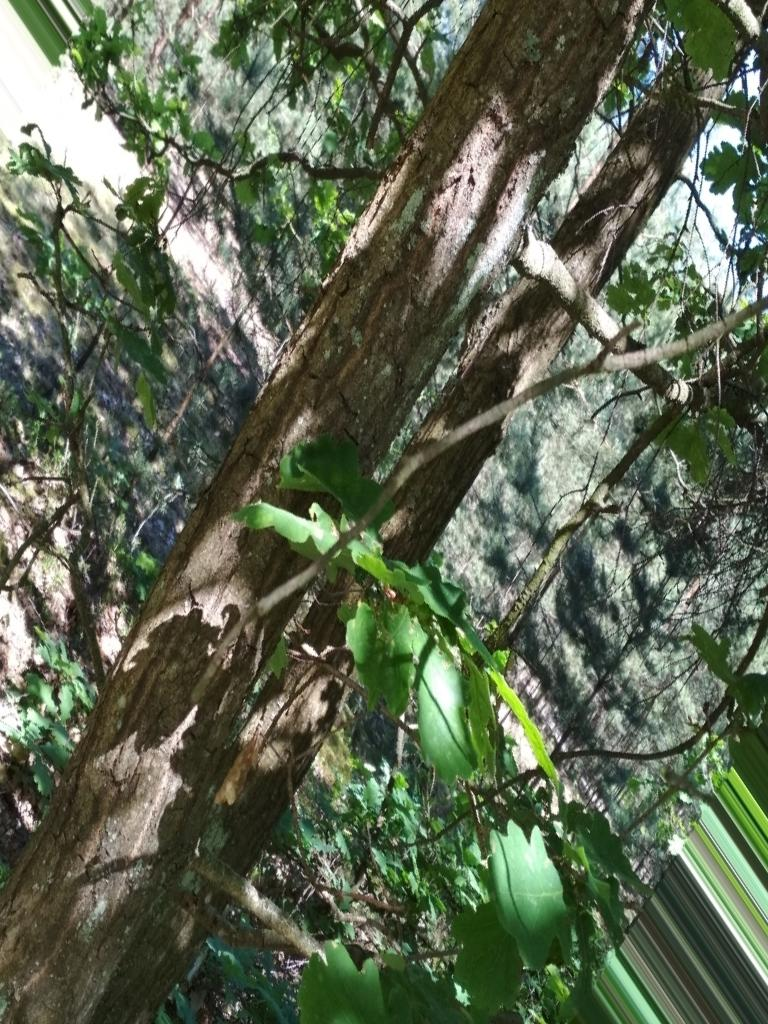

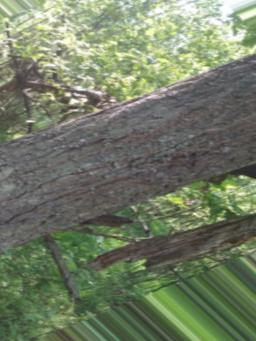

and 5 random pine augmented image examples: 


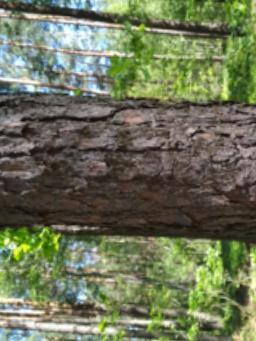

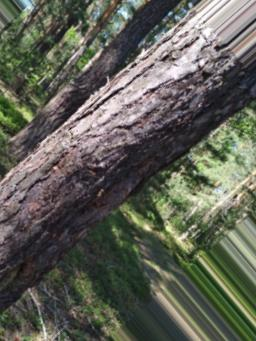

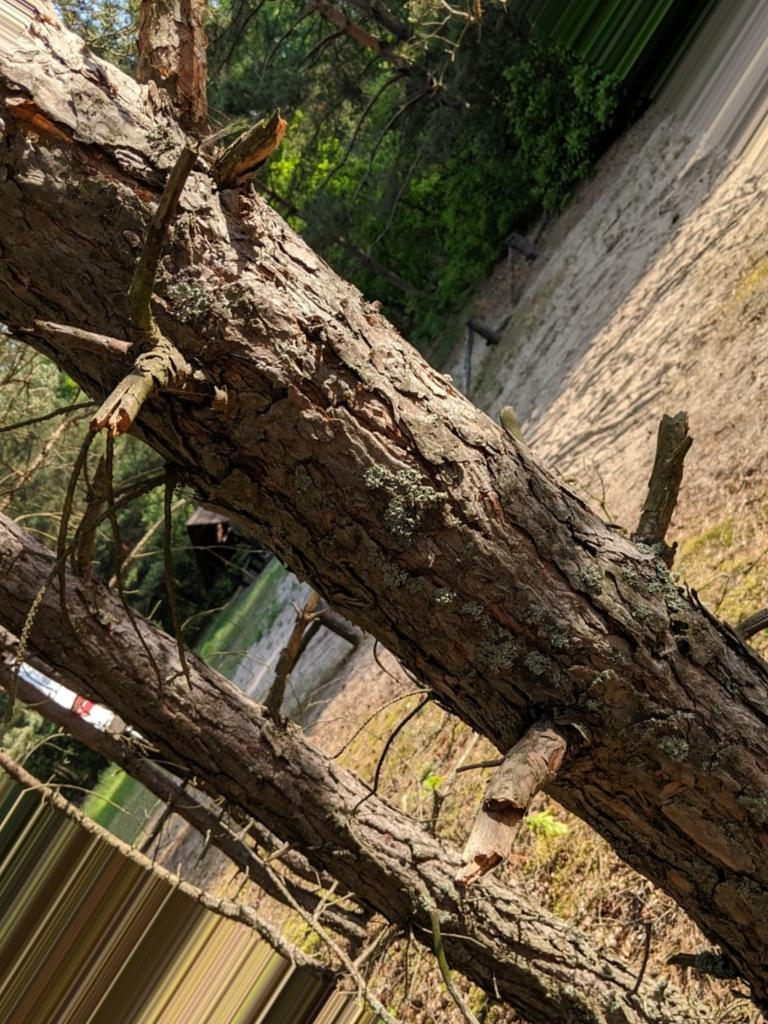

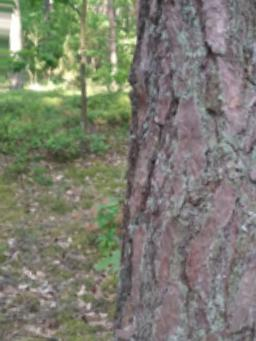

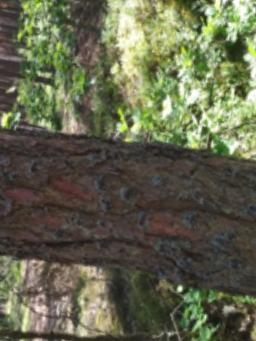

In [37]:
folder_oak_aug = "./data/aug/oak"
imgs_oak_aug = [f for f in os.listdir(folder_oak_aug) if (os.path.isfile(os.path.join(folder_oak_aug, f)) and os.path.splitext(f)[1]=='.jpg')]
folder_pine_aug = "./data/aug/pine"
imgs_pine_aug = [f for f in os.listdir(folder_pine_aug) if (os.path.isfile(os.path.join(folder_pine_aug, f))and os.path.splitext(f)[1]=='.jpg')]
print("Working with {0} oak and {1} pine augmented images".format(len(imgs_oak_aug),len(imgs_pine_aug)))

print("5 random oak augmented image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_oak_aug + "/" + imgs_oak_aug[choice(range(len(imgs_oak_aug)))], width=240, height=320))
print("and 5 random pine augmented image examples: ")
for _ in range(5):
    display(_Imgdis(filename=folder_pine_aug + "/" + imgs_pine_aug[choice(range(len(imgs_pine_aug)))], width=240, height=320))

### Train model on new data
Now we can load our new data and train model on it

In [38]:
dataset2 = np.concatenate([ds_oak2.reshape(ds_oak2.shape[0], ds_oak2.shape[2], ds_oak2.shape[3], 3),
                           ds_oak2_aug,
                           ds_pine2.reshape(ds_pine2.shape[0], ds_pine2.shape[2], ds_pine2.shape[3], 3),
                           ds_pine2_aug], axis=0)

In [39]:
labels2 = 356*['oak'] + 440*['pine']  

labels2 = [0 if label=='oak' else 1 for label in labels2]
labels2 = to_categorical(labels2)

In [41]:
dataset2 = (dataset2 - dataset2.min())/(dataset2.max() - dataset2.min())
dataset2[0]

array([[[0.14901961, 0.1882353 , 0.16470589],
        [0.20392157, 0.24705882, 0.2627451 ],
        [0.78431374, 0.8392157 , 0.8666667 ],
        ...,
        [0.56078434, 0.65882355, 0.68235296],
        [0.60784316, 0.7137255 , 0.7019608 ],
        [0.5803922 , 0.6862745 , 0.6431373 ]],

       [[0.16078432, 0.2       , 0.16862746],
        [0.19215687, 0.23529412, 0.24705882],
        [0.654902  , 0.7058824 , 0.7372549 ],
        ...,
        [0.7137255 , 0.81960785, 0.85882354],
        [0.4745098 , 0.6039216 , 0.5686275 ],
        [0.31764707, 0.45490196, 0.35686275]],

       [[0.16862746, 0.21176471, 0.16470589],
        [0.14901961, 0.19607843, 0.19607843],
        [0.45490196, 0.5058824 , 0.53333336],
        ...,
        [0.6862745 , 0.8       , 0.8117647 ],
        [0.32941177, 0.48235294, 0.39215687],
        [0.24705882, 0.42352942, 0.2509804 ]],

       ...,

       [[0.5921569 , 0.58431375, 0.627451  ],
        [0.5647059 , 0.56078434, 0.6       ],
        [0.54901963, 0

In [45]:
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(dataset2, labels2, test_size=0.1, random_state=33)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_tr2, y_tr2, test_size=0.2, random_state=33)

print("Train set size: {0}, Validation set size: {1}, Test set size: {2}"
        .format(len(y_tr2), len(y_val2), len(y_test2)))

Train set size: 572, Validation set size: 144, Test set size: 80


In [48]:
model3 = Model(inputs=mob_net.input, outputs=outs2)
   
for layer in model2.layers[:87]:
    layer.trainable=False
for layer in model2.layers[87:]:
    layer.trainable=True
model3.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model3.fit(X_tr2, y_tr2, batch_size=4, epochs=5, validation_data=(X_val2, y_val2))

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 94s 164ms/step - loss: 0.6971 - accuracy: 0.5507 - val_loss: 0.6994 - val_accuracy: 0.4792
Epoch 2/5
572/572 [==============================] - 99s 173ms/step - loss: 0.6594 - accuracy: 0.6136 - val_loss: 0.6777 - val_accuracy: 0.5625
Epoch 3/5
572/572 [==============================] - 98s 172ms/step - loss: 0.6346 - accuracy: 0.6364 - val_loss: 0.6750 - val_accuracy: 0.6042
Epoch 4/5
572/572 [==============================] - 99s 174ms/step - loss: 0.5622 - accuracy: 0.7273 - val_loss: 0.6633 - val_accuracy: 0.5764
Epoch 5/5
572/572 [==============================] - 103s 179ms/step - loss: 0.5549 - accuracy: 0.6923 - val_loss: 0.6545 - val_accuracy: 0.5833


In [51]:
preds3 = model3.predict(X_test2,batch_size=4)
preds3 = np.round(preds3, decimals=0)
preds3

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [52]:
np.mean(y_test2 == preds3)

0.475

In [53]:
model3.evaluate(X_test2, y_test2, batch_size=2)

80/80 [==============================] - 10s 127ms/step


[0.6695215404033661, 0.4749999940395355]

## Testing changes in layers
